In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from tabulate import tabulate

import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

SAVE_PLOTS = True
PATH = "./deep_learning"
if SAVE_PLOTS and not os.path.exists(PATH):
    os.mkdir(PATH)

In [19]:
# Read images and masks

images = []
masks = []

IMG_NO = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
size = (512, 512)

for i in IMG_NO:
    for letter in ['h', 'g']:
        # img = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L.jpg')
        # mask = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L_1stHO.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.imread('./all/images/' + str(i).zfill(2) + f'_{letter}.jpg')
        mask = cv2.imread('./all/manual1/' + str(i).zfill(2) + f'_{letter}.tif', cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print('Cannot read mask')
            exit(0)

        if img is None:
            print('Cannot read image')
            exit(0)

        img = img.astype(np.float32)  # konwertujemy typ danych na float32
        img = img / 255.0
        img = cv2.resize(img, size)
        images.append(img)

        mask = mask.astype(np.float32)  # konwertujemy typ danych na float32
        mask = mask / 255.0
        mask = cv2.resize(mask, size)
        masks.append(mask)

In [20]:

# Podział na zbiory treningowe i walidacyjne
X_train, X_valid, Y_train, Y_valid = train_test_split(images, masks, train_size=0.8, random_state=42)

In [21]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)


X_train shape: (16, 512, 512, 3)
Y_train shape: (16, 512, 512)
X_valid shape: (4, 512, 512, 3)
Y_valid shape: (4, 512, 512)


In [22]:
model = sm.Unet(
    'vgg16',
    input_shape=(512, 512, 3),
    classes=1,
    activation='sigmoid'
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)

In [23]:
batch_size = 2
epochs = 8

history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, Y_valid),
    callbacks=[
        ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou_score', mode='max'),
        ReduceLROnPlateau(monitor='val_iou_score', factor=0.1, patience=5, verbose=1, mode='max', min_lr=1e-6)
    ]
)

Epoch 1/8
8/8 [==============================] - 46s 6s/step - loss: 1.4236 - iou_score: 0.0946 - val_loss: 1.1920 - val_iou_score: 0.1019 - lr: 1.0000e-04
Epoch 2/8
8/8 [==============================] - 45s 6s/step - loss: 1.2972 - iou_score: 0.1281 - val_loss: 1.2009 - val_iou_score: 0.1190 - lr: 1.0000e-04
Epoch 3/8
8/8 [==============================] - 46s 6s/step - loss: 1.2283 - iou_score: 0.1505 - val_loss: 1.2795 - val_iou_score: 0.1180 - lr: 1.0000e-04
Epoch 4/8
8/8 [==============================] - 49s 6s/step - loss: 1.1841 - iou_score: 0.1660 - val_loss: 1.4015 - val_iou_score: 0.1115 - lr: 1.0000e-04
Epoch 5/8
8/8 [==============================] - 50s 6s/step - loss: 1.1484 - iou_score: 0.1793 - val_loss: 1.4208 - val_iou_score: 0.1152 - lr: 1.0000e-04
Epoch 6/8
8/8 [==============================] - 48s 6s/step - loss: 1.1165 - iou_score: 0.1914 - val_loss: 1.4759 - val_iou_score: 0.1128 - lr: 1.0000e-04
Epoch 7/8
8/8 [==============================] - ETA: 0s - loss:

1/1 [==============================] - 1s 972ms/step


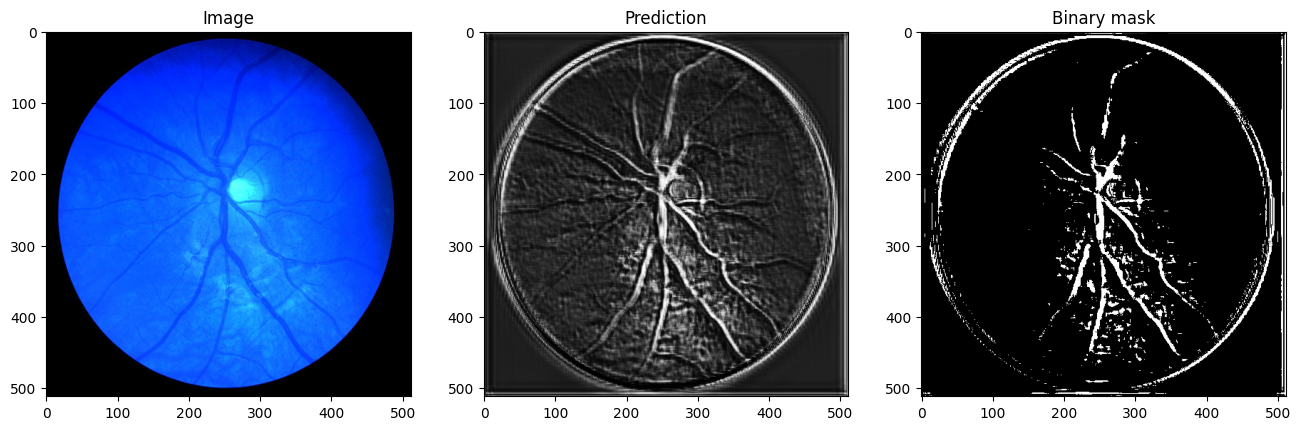

<Figure size 640x480 with 0 Axes>

In [24]:
model = load_model('best_model.h5', compile=False)

test_image = cv2.imread('./CHASEDB1/Image_' + str("11").zfill(2) + 'L.jpg', cv2.IMREAD_COLOR)
test_image = cv2.resize(test_image, (512, 512))
test_image = test_image / 255.0

test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)

prediction = np.squeeze(prediction, axis=0)

threshold = 0.5
binary_mask = (prediction >= threshold).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(test_image[0])
plt.title('Image')
plt.subplot(1, 3, 2)
plt.imshow(prediction, cmap='gray')
plt.title('Prediction')
plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary mask')
plt.show()

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/results.png')

In [25]:
# Read images to predict

IMG_NO = [11, 12, 13, 14, 15]
images = []
masks = []

for i in IMG_NO:
    img = cv2.imread('./all/images/' + str(i).zfill(2) + f'_{letter}.jpg')
    mask = cv2.imread('./all/manual1/' + str(i).zfill(2) + f'_{letter}.tif', cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print('Cannot read mask')
        exit(0)

    if img is None:
        print('Cannot read image')
        exit(0)

    img = img.astype(np.float32)
    img = img / 255.0
    img = cv2.resize(img, size)

    images.append(img)

    mask = mask.astype(np.float32)
    mask = mask / 255.0
    mask = cv2.resize(mask, size)

    masks.append(mask)

1/1 [==============================] - 1s 854ms/step


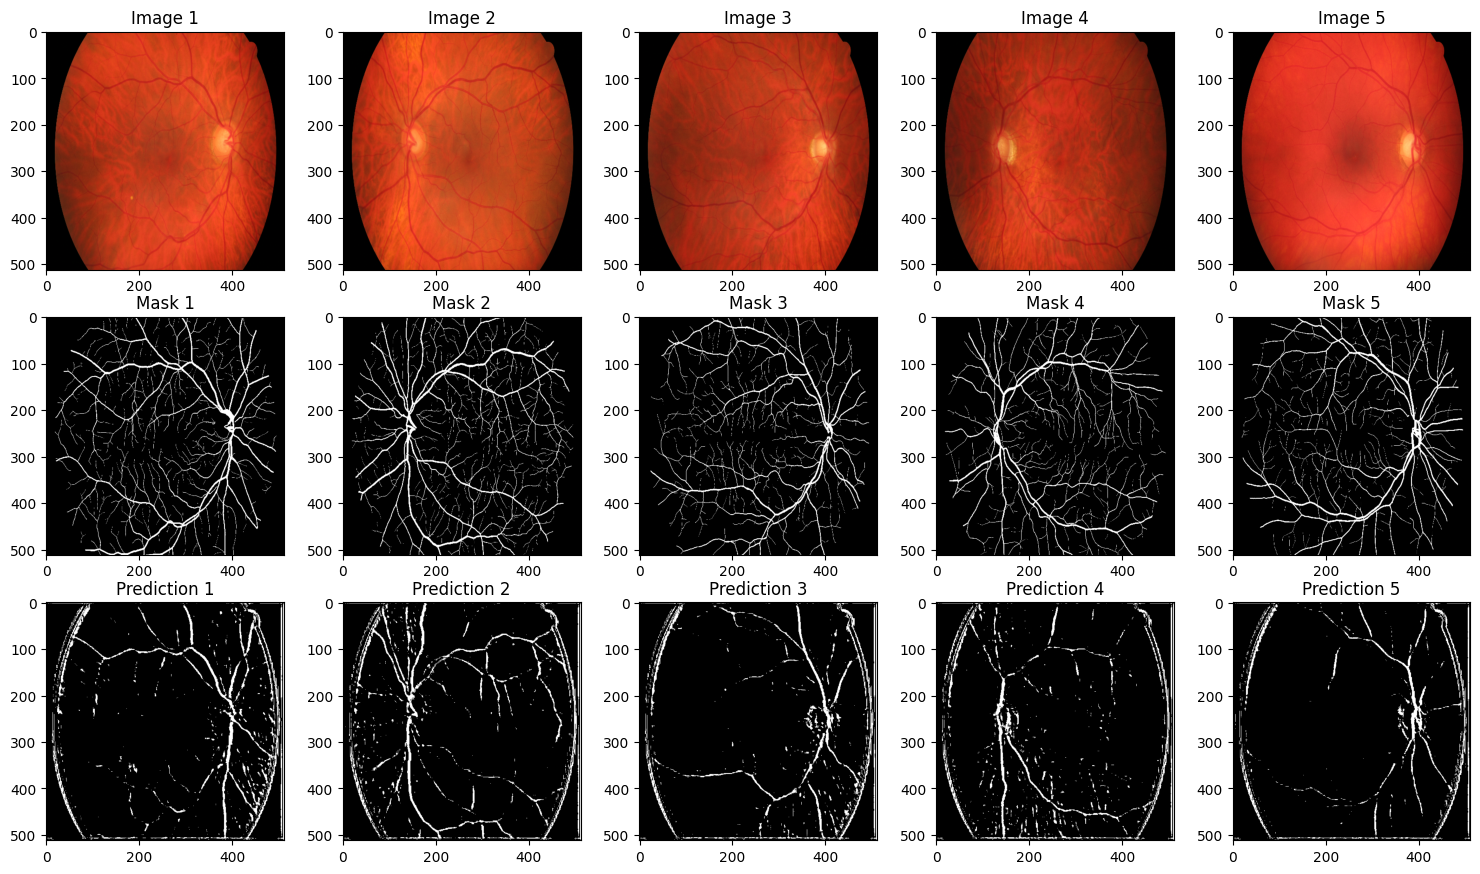

In [26]:
n = len(IMG_NO)
fig, ax = plt.subplots(3, n)
fig.set_size_inches(18.5, 10.5)

PREDICTED = []

for k, new_img, mask in zip(range(n), images, masks):

    ax[0, k].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    ax[0, k].set_title('Image ' + str(k+1))

    ax[1, k].imshow(mask, cmap='gray')
    ax[1, k].set_title('Mask ' + str(k+1))
    
    new_img = np.expand_dims(new_img, axis=0)
    y_pred = model.predict(new_img)
    y_pred = np.squeeze(y_pred, axis=0)

    threshold = 0.5
    binary_mask = (y_pred >= threshold).astype(np.uint8)
    PREDICTED.append(binary_mask)

    ax[2, k].imshow(binary_mask, cmap='gray')
    ax[2, k].set_title('Prediction ' + str(k+1))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/prediction.png')

| Method   |   Accuracy |   Sensitivity |   Specificity |
|:---------|-----------:|--------------:|--------------:|
| Image 1  |       0.89 |          0.3  |          0.3  |
| Image 2  |       0.89 |          0.35 |          0.36 |
| Image 3  |       0.9  |          0.25 |          0.25 |
| Image 4  |       0.89 |          0.24 |          0.25 |
| Image 5  |       0.9  |          0.21 |          0.27 |
| Mean     |       0.89 |          0.27 |          0.29 |


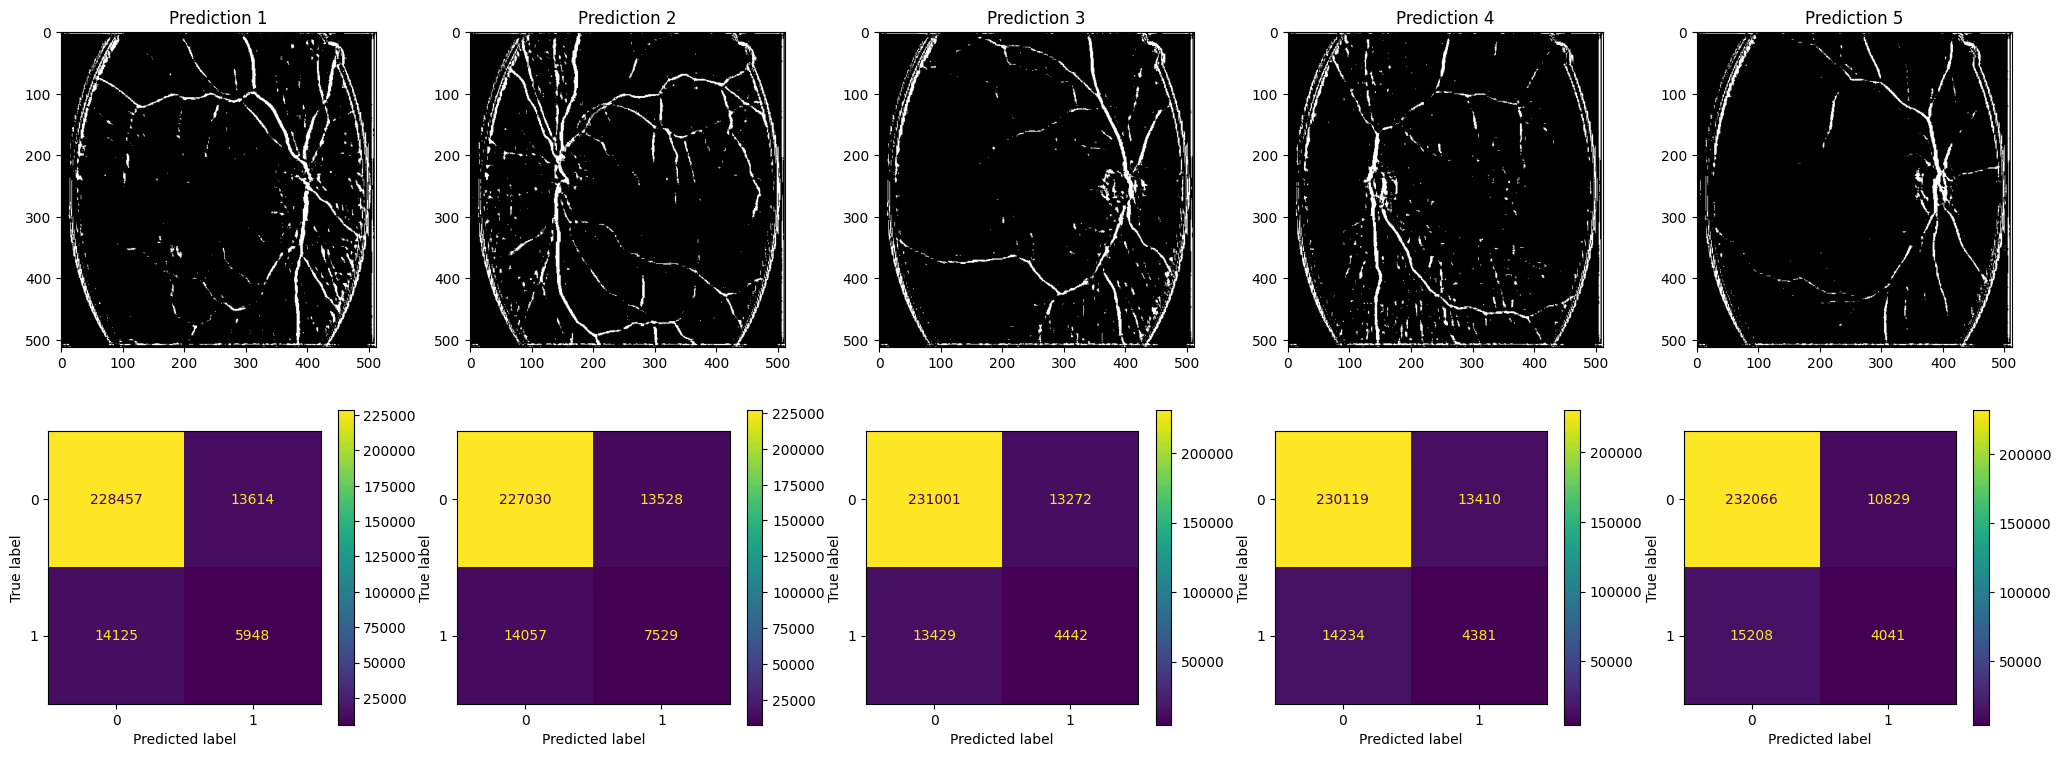

In [27]:
fig, axs = plt.subplots(2, len(IMG_NO)) 
fig.set_size_inches(25.5, 9)

headers = ["Method", "Accuracy", "Sensitivity", "Specificity"]
data = []

for i, expert_mask, predicted in zip(range(len(IMG_NO)), masks, PREDICTED):

    y_true = expert_mask.ravel()
    y_true = y_true / y_true.max()
    y_true = np.where(y_true > 0.5, 1, 0)

    
    y_pred = predicted.ravel()
    y_pred = y_pred / y_pred.max()
    y_pred = np.where(y_pred > 0.5, 1, 0)

    cm = confusion_matrix(y_true, y_pred)

    axs[0][i].imshow(predicted, cmap='gray')
    axs[0][i].set_title('Prediction ' + str(i+1))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[1][i])

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    data.append([f"Image {i+1}", f"{accuracy:.2f}", f"{recall:.2f}", f"{precision:.2f}"])

data.append(["Mean", f"{np.mean([float(x[1]) for x in data]):.2f}", f"{np.mean([float(x[2]) for x in data]):.2f}", f"{np.mean([float(x[3]) for x in data]):.2f}"])

print(tabulate(data, headers=headers, tablefmt="pipe"))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/results.png')